# <center>Лабораторная работа №7
## <center>Обучение без учителя: метод главных компонент и кластеризация

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

**Заполните код в клетках (где написано *"Ваш код здесь"*).**

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn import decomposition
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("../../Labs/ml_lab07_unsupervised_learning/samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("../../Labs/ml_lab07_unsupervised_learning/samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("../../Labs/ml_lab07_unsupervised_learning/samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("../../Labs/ml_lab07_unsupervised_learning/samsung_HAR/samsung_test_labels.txt").astype(int)

In [7]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

array([5, 5, 5, ..., 2, 2, 2])

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [16]:
np.vstack?

In [104]:
# Ваш код здесь
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

Определим число уникальных значений меток целевого класса.

In [24]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [25]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [28]:
pca = PCA(random_state = RANDOM_STATE)
X_pca = pca.fit(X_scaled)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [63]:
for i, component in enumerate(X_pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * X_pca.explained_variance_ratio_[i], 2)))


1 component: 50.74% of initial variance
2 component: 6.24% of initial variance
3 component: 2.69% of initial variance
4 component: 2.45% of initial variance
5 component: 1.89% of initial variance
6 component: 1.63% of initial variance
7 component: 1.41% of initial variance
8 component: 1.22% of initial variance
9 component: 0.99% of initial variance
10 component: 0.95% of initial variance
11 component: 0.86% of initial variance
12 component: 0.81% of initial variance
13 component: 0.77% of initial variance
14 component: 0.68% of initial variance
15 component: 0.63% of initial variance
16 component: 0.62% of initial variance
17 component: 0.6% of initial variance
18 component: 0.58% of initial variance
19 component: 0.56% of initial variance
20 component: 0.54% of initial variance
21 component: 0.52% of initial variance
22 component: 0.5% of initial variance
23 component: 0.47% of initial variance
24 component: 0.46% of initial variance
25 component: 0.45% of initial variance
26 compone

**Варианты:**
- 56 
- 65
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- 51
- 56
- 61

In [4]:
# 51

Визуализируйте данные в проекции на первые две главные компоненты.

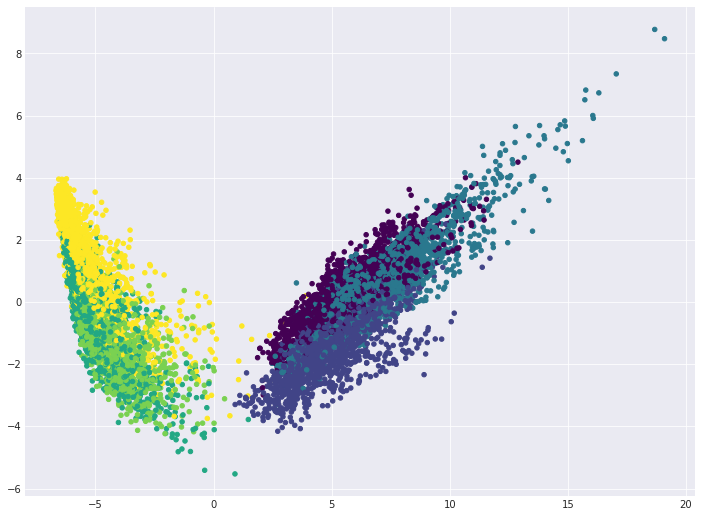

In [72]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1] , c=y, s=20, cmap='viridis');
# 2 кластера

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [109]:
kmeans = KMeans(n_clusters= n_classes, n_init = 100, random_state=RANDOM_STATE).fit(X_reduced)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

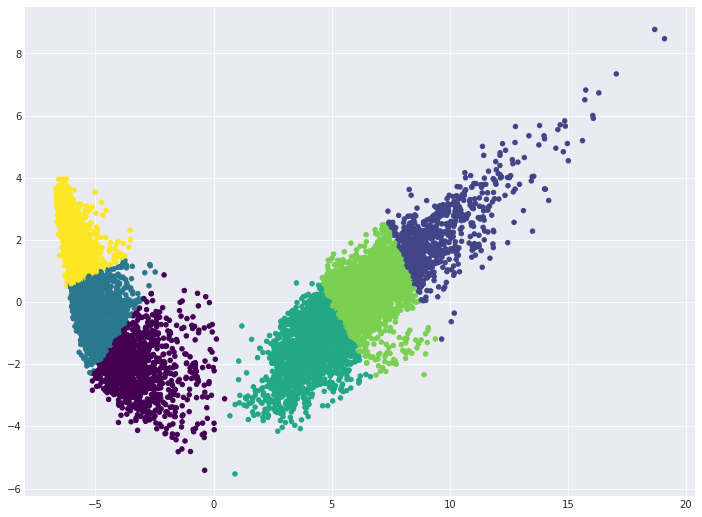

In [110]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans.labels_ , s=20,  cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [95]:
tab = pd.crosstab(y, kmeans.labels_, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab
#4

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,198,0,655,869,0,1722
подъем вверх по лестнице,0,39,0,1063,442,0,1544
спуск по лестнице,0,531,0,183,692,0,1406
сидение,333,0,894,3,0,547,1777
стояние,566,0,1113,0,0,227,1906
лежание,168,0,530,12,0,1234,1944
все,1067,768,2537,1916,2003,2008,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [90]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))


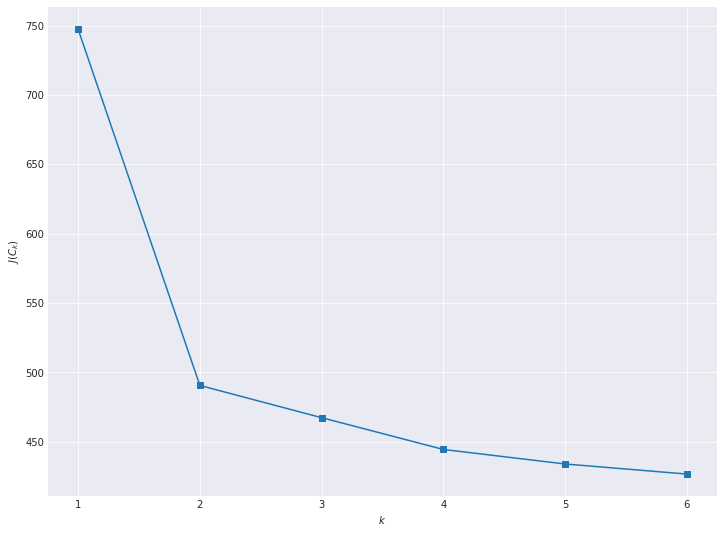

In [91]:
plt.plot(range(1, n_classes + 1), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
#4

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [97]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_reduced)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [107]:
metrics.adjusted_rand_score(y, kmeans.labels_), metrics.adjusted_rand_score(y, ag.labels_)

(0.2985524413627671, 0.3125825837921333)

-------------------------------